In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image
import cv2

In [ ]:
# Define dataset directories
base_dir = './fruits/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [ ]:

# Check if directories exist
if not os.path.exists(base_dir):
    raise Exception(f"Base directory {base_dir} does not exist.")
if not os.path.exists(train_dir):
    raise Exception(f"Training directory {train_dir} does not exist.")
if not os.path.exists(test_dir):
    raise Exception(f"Testing directory {test_dir} does not exist.")

In [ ]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using GPU: {gpus}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("No GPU found, using CPU.")

In [ ]:
# Remove corrupted images
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    for filename in os.listdir(subdir_path):
        file_path = os.path.join(subdir_path, filename)
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            print(f"Skipping {file_path} due to invalid file extension")
            continue
        try:
            with Image.open(file_path) as img:
                img.verify()
        except (IOError, SyntaxError) as e:
            print(f"Deleting corrupted file {file_path}: {e}")
            os.remove(file_path)


In [35]:
# Count images per class
class_counts = {subdir: len(os.listdir(os.path.join(train_dir, subdir))) for subdir in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, subdir))}
class_counts

{'apple': 1312,
 'avocado': 1312,
 'banana': 1312,
 'blueberry': 1312,
 'cantaloupe': 1312,
 'cherry': 1312,
 'dragonfruit': 1301,
 'emblic': 1304,
 'grape': 1312,
 'guava': 1312,
 'jackfruit': 1300,
 'kiwi': 1311,
 'lychee': 1312,
 'mango': 1312,
 'orange': 1312,
 'papaya': 1312,
 'pear': 1312,
 'pineapple': 1312,
 'pomegranate': 1312,
 'raspberry': 1312,
 'strawberry': 1312,
 'watermelon': 1312}

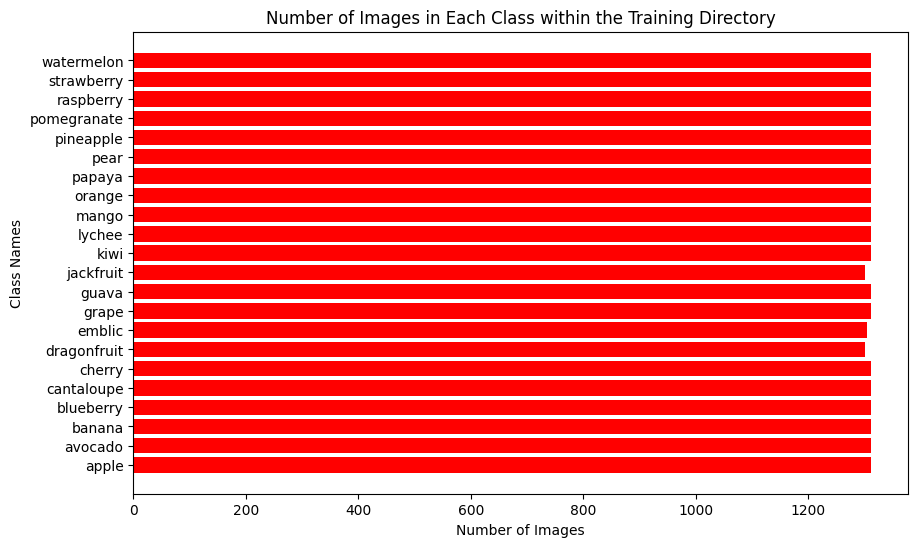

In [36]:
# Plot class distribution
plt.figure(figsize=(10, 6))
plt.barh(list(class_counts.keys()), list(class_counts.values()), color='red')
plt.xlabel('Number of Images')
plt.ylabel('Class Names')
plt.title('Number of Images in Each Class within the Training Directory')
plt.show()

In [ ]:
# Image preprocessing
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = data_gen.flow_from_directory(train_dir, target_size=(100, 100), batch_size=32, class_mode='categorical', subset='training')
val_generator = data_gen.flow_from_directory(train_dir, target_size=(100, 100), batch_size=32, class_mode='categorical', subset='validation')

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_counts), activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
epochs = 5
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, steps_per_epoch=100)

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

In [ ]:
# Evaluate on test set
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=(100, 100), batch_size=32, class_mode='categorical', shuffle=False)
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

In [ ]:
# Prediction function
def predict_image(image_path, model, class_labels):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(100, 100))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale
    
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction)
    
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()
    
    return predicted_class, confidence
    

In [ ]:
# Example usage
class_labels = list(class_counts.keys())  # Get class names
sample_image_path = './fruits/predict/dragonfruit_fruit_0.jpg'  # Replace with actual image path
if os.path.exists(sample_image_path):
    predicted_class, confidence = predict_image(sample_image_path, model, class_labels)
    print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}")
else:
    print(f"Sample image {sample_image_path} not found.")

In [ ]:
# Use webcam to predict in real-time
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if not ret:
        continue
    
    # Save the frame as an image
    cv2.imwrite('webcam.jpg', frame)
    
    # Predict the class of the saved image
    predicted_class, confidence = predict_image('webcam.jpg', model, class_labels)
    
    # Write the predicted class and confidence on the frame
    cv2.putText(frame, f"Class: {predicted_class}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(frame, f"Confidence: {confidence:.2f}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    # Display the frame
    cv2.imshow("Webcam", frame)
    
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()